In [118]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Initialize Tagger

In [168]:
from tagger import Tagger
tagger = Tagger()

### Load Model and Data

In [189]:
model_path = ''
task_name = 'QQP'
split = 'dev'
filepath = f'{task_name}_{split}_error_analysis.tsv'
print(filepath)

QQP_dev_error_analysis.tsv


In [190]:
# # Load model and data
# model, dl = load_data_and_model(model_path,task_name,split)

# # Create DataFrame of Raw Data, Predictions, and Labels
# print('Creating dataframe')
# df_error = create_dataframe(task_name, model, dl)
# print('Created dataframe')

# # Save (and reload) DataFrame
# csv_path = '/'.join(model_path.split('/')[0:-1])
# save_dataframe(df_error, filepath)

df_error = load_dataframe(filepath)
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,why are african - americans so beautiful ?,why are hispanic ##s so beautiful ?,0.017592,0,QQP/dev.tsv:2,0,False
1,1,i want to pursue phd in computer science abou...,i handle social media for a non - profit . sh...,0.001446,0,QQP/dev.tsv:3,0,False
2,2,is there a reason why we should travel alone ?,what are some reasons to travel alone ?,0.935732,1,QQP/dev.tsv:4,1,False
3,3,why are people so obsessed with having a girl...,how can a single male have a child ?,0.001505,0,QQP/dev.tsv:5,0,False
4,4,what are some good baby girl names starting w...,what are some good baby girl names starting w...,0.149290,0,QQP/dev.tsv:6,0,False


## Sandbox for Error Analysis

Plotting probabilities from the first column of Y_probs


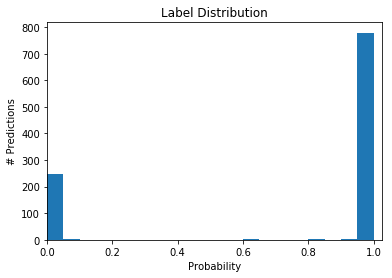

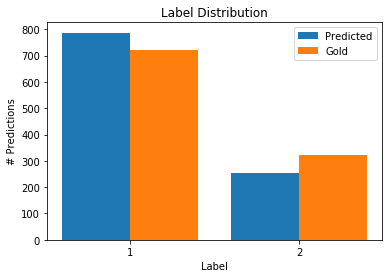

Plotting probabilities from the first column of Y_probs


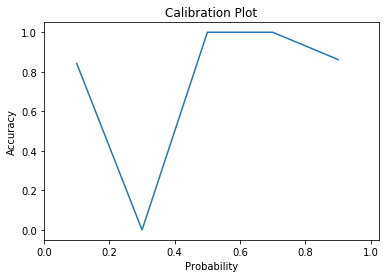

In [184]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()

from metal.contrib.visualization.analysis import (
        plot_predictions_histogram, 
        plot_probabilities_histogram,
        plot_calibration_plot
    )
plot_probabilities_histogram(Y_probs, title="Label Distribution")
plot_predictions_histogram(Y_preds, Y_gold, title="Label Distribution")
plot_calibration_plot(Y_probs, Y_gold, title="Calibration Plot", bins=5)

# Examples we got barely right, barely wrong, and very wrong

In [185]:
print("\033[1mBARELY RIGHT\033[0;0m")
print_barely_right(df_error, thresh=0.2, n=1)
print("\033[1mBARELY WRONG\033[0;0m")
print_barely_wrong(df_error, thresh=0.2, n=1)
print("\033[1mVERY WRONG\033[0;0m")
print_very_wrong(df_error, thresh=0.8, n=1)

BARELY RIGHT
4 matches were found with the given criteria.

UID:  CoLA/dev.tsv:1004
sentence1: 	 John left orders to follow Pete . 
sentence2: 	nan
score: 	0.6494
label: 	1

BARELY WRONG
1 matches were found with the given criteria.

UID:  CoLA/dev.tsv:857
sentence1: 	 They preferred them arrested . 
sentence2: 	nan
score: 	0.3966
label: 	1

VERY WRONG
148 matches were found with the given criteria.

UID:  CoLA/dev.tsv:885
sentence1: 	 Pro ##tec ##t you ! 
sentence2: 	nan
score: 	0.9999
label: 	0



# Slicing

In [186]:
from metal.mmtl.debugging.utils import print_row, apply_lfs_to_df, view_matches
from metal.mmtl.debugging.lf_helpers import regex_present
df_error.head()

,Unnamed: 0,sentence1,sentence2,score,label,uid,pred,is_wrong
0,0,The weights made the rope stretch over the pu...,NaN,0.999909,1,CoLA/dev.tsv:2,1,False
1,1,The mechanical doll w ##rig ##gled itself loo...,NaN,0.000127,1,CoLA/dev.tsv:3,0,True
2,2,"If you had eaten more , you would want less .",NaN,0.999914,1,CoLA/dev.tsv:4,1,False
3,3,"As you eat the most , you want the least .",NaN,0.999184,0,CoLA/dev.tsv:5,1,True
4,4,"The more you would want , the less you would ...",NaN,0.999899,0,CoLA/dev.tsv:6,1,True


In [191]:
def slicing_function(row):
    people = 0
    for pronoun in ['she','her','hers']:
        if regex_present(row,pronoun,fields=['sentence1']):
            people += 1
            continue
    for pronoun in ['he','him','his']:
        if regex_present(row,pronoun,fields=['sentence1']):
            people += 1
            continue
    for pronoun in ['you','your','yours']:
        if regex_present(row,pronoun,fields=['sentence1']):
            people += 1
            continue
    for pronoun in ['I','my','me','mine']:
        if regex_present(row,pronoun,fields=['sentence1']):
            people += 1
            continue
    return people > 3

from slicing import slice_dashsemicolon
    
df = df_error[['sentence1','sentence2']].apply(slicing_function, axis=1)
in_slice = df_error[df]
print(in_slice.head())

    Unnamed: 0                                          sentence1  \
3            3   why are people so obsessed with having a girl...   
9            9                       why should i crack je ##e ?    
11          11   can anyone tell shall mi mix mobile should be...   
13          13         why tamil nadu universities are no good ?    
14          14   what is an easy way to clean tooth ##pas ##te...   

                                            sentence2     score  label  \
3               how can a single male have a child ?   0.001505      0   
9    is it possible to get into ii ##ms with low m...  0.001265      0   
11   " what did volta ##ire mean when he said , " ...  0.001189      0   
13   why are the 10th students able to score 100 %...  0.002752      0   
14   what are some ways to remove hard water stain...  0.004020      0   

               uid  pred  is_wrong  
3    QQP/dev.tsv:5     0     False  
9   QQP/dev.tsv:11     0     False  
11  QQP/dev.tsv:13     0     

In [192]:
from metal.analysis import confusion_matrix
from metal.utils import convert_labels

Y_gold = convert_labels(df_error['label'].values, "onezero", "categorical")
Y_preds = convert_labels(df_error['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([df_error['score'].values, 1 - df_error['score'].values]).transpose()
print('IN ENTIRE {} DATASET'.format(task_name))

from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(df_error)} examples in the dataset')
    
Y_gold = convert_labels(in_slice['label'].values, "onezero", "categorical")
Y_preds = convert_labels(in_slice['pred'].values, "onezero", "categorical")
Y_probs = np.vstack([in_slice['score'].values, 1 - in_slice['score'].values]).transpose()
print('\nIN SLICE')
    
from metal.metrics import metric_score
metric_list = ['accuracy','precision', 'recall', 'f1']

for metric in metric_list:
    score = metric_score(Y_gold, Y_preds, metric, probs=Y_probs)
    print(f"{metric.capitalize()}: {score:.3f}")
print(f'There are {len(in_slice)} examples in the slice')

IN ENTIRE QQP DATASET
Accuracy: 0.887
Precision: 0.836
Recall: 0.863
F1: 0.849
There are 40430 examples in the dataset

IN SLICE
Accuracy: 0.877
Precision: 0.826
Recall: 0.855
F1: 0.840
There are 10694 examples in the slice


In [167]:
filename = f'slices/{task_name}_{split}_4people.tsv'
print(in_slice)
in_slice['uid'].to_csv(filename,sep='\t',header=False,index=False)

       Unnamed: 0                                          sentence1  \
38             38   what people who you ' ve never met have influ...   
57             57   can i use mod ##s in ps ##2 games like gt ##a...   
90             90   ft ##m : how much of an effect did testostero...   
109           109   your girlfriend / wife refused to have an abo...   
129           129   what does it mean when a girl take a day to r...   
292           292   selena gomez ( actor , musician ) : did you l...   
362           362   have you ever found out your friend doesn ' t...   
377           377   i got an internship at ibm . will this help m...   
378           378   have you ever encountered any supernatural ph...   
497           497   how much flu ##ori ##de is absorbed into your...   
557           557      i cheated on my wife would she cheat on me ?    
578           578         how did you meet your significant other ?    
671           671   while i am requesting online sb ##i global d

**1. Number Based LF**

Our model tends to fail when there are numbers involved in the two sentences. We can look for the same number being repeated in both sentences as an LF

**2. Edit Distance Based LF**

Our model tends to vote entailment when one sentence is long and the other is short. We can focus on this slice and flip the labelt o vote no entailment even when the number of words is the same.